The goal of this notebook is to assess the functional impact of missense variants by comparing the probabilities of mutated and reference protein sequences

# Setup

In [ ]:
#import dependencies
import os.path
#os.chdir("set working path here")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers.models.esm.modeling_esm import EsmPreTrainedModel, EsmModel
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

# for custom DataCollator
from transformers.data.data_collator import DataCollatorMixin
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy

import peft
from peft import get_peft_config, PeftModel, PeftConfig, inject_adapter_in_model, LoraConfig

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import warnings
import logging

In [2]:
warnings.filterwarnings("ignore")
logging.disable(logging.INFO)

In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.4.0+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  1.4.2
Transformers version:  4.46.2
Datasets version:  3.1.0


In [4]:
ESMs = ["facebook/esm2_t6_8M_UR50D",
         "facebook/esm2_t12_35M_UR50D",
         "facebook/esm2_t30_150M_UR50D",
         "facebook/esm2_t33_650M_UR50D",
         "facebook/esm2_t36_3B_UR50D"]

ProtT5 = ["Rostlab/prot_t5_xl_uniref50"]

selected_checkpoint = "facebook/esm2_t36_3B_UR50D"

# Model architecture

In [5]:
class EsmForTokenClassificationCustom(EsmPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.esm = EsmModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.esm(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        # changed to ignore special tokens at the seq start and end 
        # as well as invalid positions (labels -100)
        if labels is not None:
            loss_fct = CrossEntropyLoss()

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)

            active_labels = torch.where(
              active_loss, labels.view(-1), torch.tensor(-100).type_as(labels)
            )

            valid_logits=active_logits[active_labels!=-100]
            valid_labels=active_labels[active_labels!=-100]
            
            valid_labels=valid_labels.type(torch.LongTensor).to('cuda:0')
            
            loss = loss_fct(valid_logits, valid_labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    
# based on transformers DataCollatorForTokenClassification
@dataclass
class DataCollatorForTokenClassificationESM(DataCollatorMixin):
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (`int`, *optional*, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
        return_tensors (`str`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100
    return_tensors: str = "pt"

    def torch_call(self, features):
        import torch

        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature[label_name] for feature in features] if label_name in features[0].keys() else None

        no_labels_features = [{k: v for k, v in feature.items() if k != label_name} for feature in features]

        batch = self.tokenizer.pad(
            no_labels_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        if labels is None:
            return batch

        sequence_length = batch["input_ids"].shape[1]
        padding_side = self.tokenizer.padding_side

        def to_list(tensor_or_iterable):
            if isinstance(tensor_or_iterable, torch.Tensor):
                return tensor_or_iterable.tolist()
            return list(tensor_or_iterable)

        if padding_side == "right":
            batch[label_name] = [
                # to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)) for label in labels
                # changed to pad the special tokens at the beginning and end of the sequence
                [self.label_pad_token_id] + to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)-1) for label in labels
            ]
        else:
            batch[label_name] = [
                [self.label_pad_token_id] * (sequence_length - len(label)) + to_list(label) for label in labels
            ]

        batch[label_name] = torch.tensor(batch[label_name], dtype=torch.float)
        return batch

def _torch_collate_batch(examples, tokenizer, pad_to_multiple_of: Optional[int] = None):
    """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""
    import torch

    # Tensorize if necessary.
    if isinstance(examples[0], (list, tuple, np.ndarray)):
        examples = [torch.tensor(e, dtype=torch.long) for e in examples]

    length_of_first = examples[0].size(0)

    # Check if padding is necessary.

    are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
    if are_tensors_same_length and (pad_to_multiple_of is None or length_of_first % pad_to_multiple_of == 0):
        return torch.stack(examples, dim=0)

    # If yes, check if we have a `pad_token`.
    if tokenizer._pad_token is None:
        raise ValueError(
            "You are attempting to pad samples but the tokenizer you are using"
            f" ({tokenizer.__class__.__name__}) does not have a pad token."
        )

    # Creating the full tensor and filling it with our data.
    max_length = max(x.size(0) for x in examples)
    if pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of
    result = examples[0].new_full([len(examples), max_length], tokenizer.pad_token_id)
    for i, example in enumerate(examples):
        if tokenizer.padding_side == "right":
            result[i, : example.shape[0]] = example
        else:
            result[i, -example.shape[0] :] = example
    return result

def tolist(x):
    if isinstance(x, list):
        return x
    elif hasattr(x, "numpy"):  # Checks for TF tensors without needing the import
        x = x.numpy()
    return x.tolist()


# Load fine-tuned weights

In [6]:
#load ESM2 models
def load_esm_model_classification(checkpoint, num_labels, half_precision, full=False, deepspeed=False):
    
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    if half_precision and deepspeed:
        model = EsmForTokenClassificationCustom.from_pretrained(checkpoint, num_labels = num_labels, torch_dtype = torch.float16)
    else:
        model = EsmForTokenClassificationCustom.from_pretrained(checkpoint, num_labels = num_labels)
        
    if full == True:
        return model, tokenizer 
        
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    ## Unfreeze the prediction head
    #for (param_name, param) in model.classifier.named_parameters():
    #    param.requires_grad = True  
    
    return model, tokenizer

In [7]:
def load_model(checkpoint, filepath, num_labels=2, half_precision = True, full = False, deepspeed=False):
# Creates a new PT5 model and loads the finetuned weights from a file
#example: tokenizer, model_reload = load_model(checkpoint, f"./fine_tuned_models/{checkpoint}/{all_features_re[0]}.pth", num_labels=2)
    
    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model_classification(checkpoint, num_labels, half_precision, full, deepspeed)
    else:
        model, tokenizer = load_T5_model_classification(checkpoint, num_labels, half_precision, full, deepspeed)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [8]:
def single_inference(model, tokenizer, aa_seq, checkpoint):
    # Preprocess the input sequence
    aa_seq = aa_seq.replace("O", "X").replace("B", "X").replace("U", "X").replace("Z", "X")
    
    if "prot_t5" in checkpoint:
        aa_seq = " ".join(aa_seq)

    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input
    encoded = tokenizer(
        aa_seq,
        return_tensors="pt",
        padding="longest",
        truncation=True,
        is_split_into_words=False,
    )

    # Move inputs to device
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # shape: (1, seq_len, num_classes)
        probs = torch.softmax(logits, dim=-1)

    return probs[:,1:-1,1].squeeze().tolist()  #probability of being 1 (remove special tokens)
    

In [9]:
all_features = ['Active site', 'Binding site', 'DNA binding', 
                'Topological domain', 'Transmembrane',
                'Disulfide bond', 'Modified residue', 'Propeptide', 'Signal peptide', 'Transit peptide',
                'Beta strand', 'Helix', 'Turn',
                'Coiled coil', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region', 'Repeat', 'Zinc finger']

all_features_re = ['ACT_SITE', 'BINDING', 'DNA_BIND', 
                   'TOPO_DOM', 'TRANSMEM',
                   'DISULFID', 'MOD_RES',  'PROPEP', 'SIGNAL', 'TRANSIT',
                   'STRAND', 'HELIX', 'TURN',
                   'COILED', 'COMPBIAS', 'DOMAIN', 'MOTIF', 'REGION', 'REPEAT', 'ZN_FING']

# Function to identify loss or gain of features

In [10]:
def loss_or_gain(seq_ref, seq_mut, tokenizer, model, classification_threshold=0.5):
    
    diff_results = {}

    # inference
    with torch.no_grad():
      scores_ref = single_inference(model, tokenizer, seq_ref, selected_checkpoint) 
      scores_mut = single_inference(model, tokenizer, seq_mut, selected_checkpoint)

    # prob to label
    label_ref = [1 if x > classification_threshold else 0 for x in scores_ref]
    label_mut = [1 if x > classification_threshold else 0 for x in scores_mut]

    # change in labels
    diff_label = np.array(label_mut) - np.array(label_ref)
    
    gain = np.where(diff_label>0)[0].tolist()
    loss = np.where(diff_label<0)[0].tolist()
    diff_results[f"{feature_re}_label_loss"] = loss
    diff_results[f"{feature_re}_label_gain"] = gain

    # keep score
    diff_scores = np.array(scores_mut) - np.array(scores_ref)

    if len(gain) > 0:
        diff_results[f"{feature_re}_gain_score"] = diff_scores[gain]
    
    if len(loss) > 0:
        diff_results[f"{feature_re}_loss_score"] = diff_scores[loss]

    return diff_results


### run for all pathogenic/benign missense variants from ClinGen

In [11]:
clingen_vars = pd.read_csv("../data/mutation_data/clingen_onlymissense_bothPandB_54genes.tsv.gz", sep = "\t")
clingen_vars.head()

,#Variation,ClinVar Variation Id,Allele Registry Id,HGVS Expressions,SYMBOL,Disease,Mondo Id,Mode of Inheritance,Assertion,Applied Evidence Codes (Met),...,Retracted,Evidence Repo Link,Uuid,mutation,AA1,AA_pos,AA2,Sequence,Length,uniprot_entry
0,NM_206933.2(USH2A):c.15562A>G (p.Ser5188Gly),48468,CA143409,"NM_206933.2:c.15562A>G, NC_000001.11:g.2156258...",USH2A,Usher syndrome,MONDO:0019501,Autosomal recessive inheritance,Benign,BA1,...,False,https://erepo.genome.network/evrepo/ui/classif...,6ea1fef2-f5b3-4739-8738-c6bf29fea20a,p.Ser5188Gly,Ser,5188,Gly,MNCPVLSLGSGFLFQVIEMLIFAYFASISLTESRGLFPRLENVGAF...,5202,O75445
1,NM_000441.1(SLC26A4):c.1363A>T (p.Ile455Phe),43507,CA132664,"NM_000441.1:c.1363A>T, NC_000007.14:g.10769464...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,"PP3, BA1",...,False,https://erepo.genome.network/evrepo/ui/classif...,2b9fd19d-de91-41b2-a416-dc26fa5062e4,p.Ile455Phe,Ile,455,Phe,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511
2,NM_000441.1(SLC26A4):c.565G>T (p.Ala189Ser),43560,CA132732,"NM_000441.1:c.565G>T, NC_000007.14:g.107674313...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,BA1,...,False,https://erepo.genome.network/evrepo/ui/classif...,b905ae85-8973-4ed6-b603-52b3b342f2e0,p.Ala189Ser,Ala,189,Ser,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511
3,NM_000257.4(MYH7):c.4130C>T (p.Thr1377Met),42992,CA014494,"NM_000257.4:c.4130C>T, NC_000014.9:g.23418249G...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,"PS4, PM2, PP3, PP1_Strong",...,False,https://erepo.genome.network/evrepo/ui/classif...,f4dea66d-87b3-467f-862c-c239472e6930,p.Thr1377Met,Thr,1377,Met,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883
4,NM_000257.4(MYH7):c.4066G>A (p.Glu1356Lys),164294,CA014400,"NM_000257.4:c.4066G>A, NC_000014.9:g.23418313C...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,"PS4, PM2, PP3, PP1_Strong",...,False,https://erepo.genome.network/evrepo/ui/classif...,8112b9be-baa4-485d-a686-c223e112af4e,p.Glu1356Lys,Glu,1356,Lys,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883


In [12]:
amino_acids_data = [
    ["Ala", "A"],
    ["Arg", "R"],
    ["Asn", "N"],
    ["Asp", "D"],
    [ "Cys", "C"],
    [ "Gln", "Q"],
    [ "Glu", "E"],
    ["Gly", "G"],
    ["His", "H"],
    ["Ile", "I"],
    ["Leu", "L"],
    ["Lys", "K"],
    [ "Met", "M"],
    [ "Phe", "F"],
    [ "Pro", "P"],
    ["Ser", "S"],
    [ "Thr", "T"],
    [ "Trp", "W"],
    [ "Tyr", "Y"],
    [ "Val", "V"]
]

# Create a DataFrame
df_amino_acids = pd.DataFrame(amino_acids_data, columns=["AA2", "AA2_symbol"])

# add AA symbol to clingen
clingen_vars = clingen_vars.merge(df_amino_acids, how="left", on="AA2")

In [13]:
# Run only once
'''
for feature_re in all_features_re:
    clingen_vars[f'diff_results_{feature_re}'] = None

for feature_re in all_features_re:
    print(feature_re)
    # load model
    finetuned_params_path = f'../res/models/ft_{feature_re}_{selected_checkpoint.split("/")[1]}.pth'
    tokenizer, model = load_model(selected_checkpoint, finetuned_params_path)
    
    for idx, row in tqdm(clingen_vars.iterrows(), total=len(clingen_vars)):
    #for idx, row in tqdm(clingen_vars[0:5].iterrows(), total=2):
        
        ref_seq = row["Sequence"]
        var_pos = row["AA_pos"] - 1
        mut_seq = ref_seq[:var_pos] + row["AA2_symbol"] + ref_seq[var_pos+1:]
        
        try:
            clingen_vars.at[idx, f'diff_results_{feature_re}'] = loss_or_gain(ref_seq, mut_seq, tokenizer, model)
        except Exception as e:
            print(f"Error: {e}")
            print(f'skipped row {idx}')
            continue
            
        if idx%50==0:
            print(idx)
            clingen_vars.to_csv("../res/mutation_clingen/clingen_onlymissense_bothPandB_54genes_withDiffRes_esm3B.tsv.gz", sep="\t")
    
clingen_vars.to_csv("../res/mutation_clingen/clingen_onlymissense_bothPandB_54genes_withDiffRes_esm3B.tsv.gz", sep="\t")
'''

'\nfor feature_re in all_features_re:\n    clingen_vars[f\'diff_results_{feature_re}\'] = None\n\nfor feature_re in all_features_re:\n    print(feature_re)\n    # load model\n    finetuned_params_path = f\'../res/models/ft_{feature_re}_{selected_checkpoint.split("/")[1]}.pth\'\n    tokenizer, model = load_model(selected_checkpoint, finetuned_params_path)\n    \n    for idx, row in tqdm(clingen_vars.iterrows(), total=len(clingen_vars)):\n    #for idx, row in tqdm(clingen_vars[0:5].iterrows(), total=2):\n        \n        ref_seq = row["Sequence"]\n        var_pos = row["AA_pos"] - 1\n        mut_seq = ref_seq[:var_pos] + row["AA2_symbol"] + ref_seq[var_pos+1:]\n        \n        try:\n            clingen_vars.at[idx, f\'diff_results_{feature_re}\'] = loss_or_gain(ref_seq, mut_seq, tokenizer, model)\n        except Exception as e:\n            print(f"Error: {e}")\n            print(f\'skipped row {idx}\')\n            continue\n            \n        if idx%50==0:\n            print(idx)

Analyze predictions

In [14]:
# Run the following to load the clingen mutation workflow results

import re
import ast

def preprocess_and_extract(dict_string):
    # Preprocess to replace numpy array with list
    dict_string = re.sub(r'\s+', ' ', dict_string)  # Simplify all whitespace to single spaces
    dict_string = re.sub(r"array\(\s*\[([^\]]+)\]\s*\)", r"[\1]", dict_string)  # Replace 'array([...])' with '[...]'

    # Regex pattern to match keys and values in the dictionary string
    pattern = r"'(\w+)': (\[.*?\])"

    # Find all matches of the pattern in the string
    matches = re.findall(pattern, dict_string)

    result_dict = {}
    for key, value_str in matches:
        # Evaluate the list safely, converting it back from string to list/array
        try:
            # If the value is formatted like a list, convert it
            value = eval(value_str)
        except:
            value = value_str

        result_dict[key] = value

    return result_dict


clingen_vars = pd.read_csv("../res/mutation_clingen/clingen_onlymissense_bothPandB_54genes_withDiffRes_esm3B.tsv.gz", sep="\t")
clingen_vars['diff_results'] = clingen_vars['diff_results'].str.replace(', dtype=float32', '', regex=False) #,\n      dtype=float32
clingen_vars['diff_results'] = clingen_vars['diff_results'].str.replace(',\n      dtype=float32', '', regex=False)
clingen_vars["diff_results"] = clingen_vars["diff_results"].apply(preprocess_and_extract)
clingen_vars.head()


,Unnamed: 0,#Variation,ClinVar Variation Id,Allele Registry Id,HGVS Expressions,SYMBOL,Disease,Mondo Id,Mode of Inheritance,Assertion,...,Uuid,mutation,AA1,AA_pos,AA2,Sequence,Length,uniprot_entry,AA2_symbol,diff_results
0,0,NM_206933.2(USH2A):c.15562A>G (p.Ser5188Gly),48468,CA143409,"NM_206933.2:c.15562A>G, NC_000001.11:g.2156258...",USH2A,Usher syndrome,MONDO:0019501,Autosomal recessive inheritance,Benign,...,6ea1fef2-f5b3-4739-8738-c6bf29fea20a,p.Ser5188Gly,Ser,5188,Gly,MNCPVLSLGSGFLFQVIEMLIFAYFASISLTESRGLFPRLENVGAF...,5202,O75445,G,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
1,1,NM_000441.1(SLC26A4):c.1363A>T (p.Ile455Phe),43507,CA132664,"NM_000441.1:c.1363A>T, NC_000007.14:g.10769464...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,...,2b9fd19d-de91-41b2-a416-dc26fa5062e4,p.Ile455Phe,Ile,455,Phe,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511,F,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
2,2,NM_000441.1(SLC26A4):c.565G>T (p.Ala189Ser),43560,CA132732,"NM_000441.1:c.565G>T, NC_000007.14:g.107674313...",SLC26A4,Pendred syndrome,MONDO:0010134,Autosomal recessive inheritance,Benign,...,b905ae85-8973-4ed6-b603-52b3b342f2e0,p.Ala189Ser,Ala,189,Ser,MAAPGGRSEPPQLPEYSCSYMVSRPVYSELAFQQQHERRLQERKTL...,780,O43511,S,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
3,3,NM_000257.4(MYH7):c.4130C>T (p.Thr1377Met),42992,CA014494,"NM_000257.4:c.4130C>T, NC_000014.9:g.23418249G...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,...,f4dea66d-87b3-467f-862c-c239472e6930,p.Thr1377Met,Thr,1377,Met,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883,M,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."
4,4,NM_000257.4(MYH7):c.4066G>A (p.Glu1356Lys),164294,CA014400,"NM_000257.4:c.4066G>A, NC_000014.9:g.23418313C...",MYH7,hypertrophic cardiomyopathy,MONDO:0005045,Autosomal dominant inheritance,Pathogenic,...,8112b9be-baa4-485d-a686-c223e112af4e,p.Glu1356Lys,Glu,1356,Lys,MGDSEMAVFGAAAPYLRKSEKERLEAQTRPFDLKKDVFVPDDKQEF...,1935,P12883,K,"{'ACT_SITE_loss': [], 'ACT_SITE_gain': [], 'BI..."


In [15]:
import re
import ast
import numpy as np
import pandas as pd

thresholds = [round(t, 1) for t in np.arange(0.1, 1.0, 0.1)]
num_features = len(all_features)

# Initialize columns for each threshold and feature
for threshold in thresholds:
    for feature_re in all_features_re:
        clingen_vars[f"n_gain_{feature_re}_th{threshold}"] = 0
        clingen_vars[f"n_loss_{feature_re}_th{threshold}"] = 0

# Initialize all_scores only once per feature
for feature_re in all_features_re:
    clingen_vars[f"all_scores_{feature_re}"] = [[] for _ in range(len(clingen_vars))]

# Main loop
for idx, row in clingen_vars.iterrows():
    sequence_length = row["Length"]
    diff_results = row["diff_results"]

    loss_matrix = np.zeros((num_features, sequence_length))
    gain_matrix = np.zeros((num_features, sequence_length))

    for i in range(num_features):
        feature_re = all_features_re[i]
        loss_positions = diff_results.get(f"{feature_re}_loss", [])
        gain_positions = diff_results.get(f"{feature_re}_gain", [])
        loss_scores = diff_results.get(f"{feature_re}_loss_score", [])
        gain_scores = diff_results.get(f"{feature_re}_gain_score", [])

        for k, pos in enumerate(loss_positions):
            loss_matrix[i, pos - 1] = np.abs(loss_scores[k])
        for k, pos in enumerate(gain_positions):
            gain_matrix[i, pos - 1] = np.abs(gain_scores[k])

    feature_matrix = gain_matrix - loss_matrix

    for j, feature_re in enumerate(all_features_re):
        # Store scores once
        clingen_vars.at[idx, f"all_scores_{feature_re}"] = feature_matrix[j, :].reshape(-1).tolist()
        # Store thresholded counts per threshold
        for threshold in thresholds:
            clingen_vars.at[idx, f"n_loss_{feature_re}_th{threshold}"] = int(np.sum(feature_matrix[j, :] < -threshold))
            clingen_vars.at[idx, f"n_gain_{feature_re}_th{threshold}"] = int(np.sum(feature_matrix[j, :] > threshold))


In [16]:
# Prepare data for ridge plot
ridge_data = []

for feature in all_features_re:
    column_name = f'all_scores_{feature}'
    df = clingen_vars.explode(column_name)
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df = df[df[column_name] != 0]
    df['feature'] = feature
    df = df.rename(columns={column_name: 'score'})
    ridge_data.append(df[['score', 'Assertion', 'feature']])

# Combine data for all features
ridge_data = pd.concat(ridge_data, ignore_index=True)

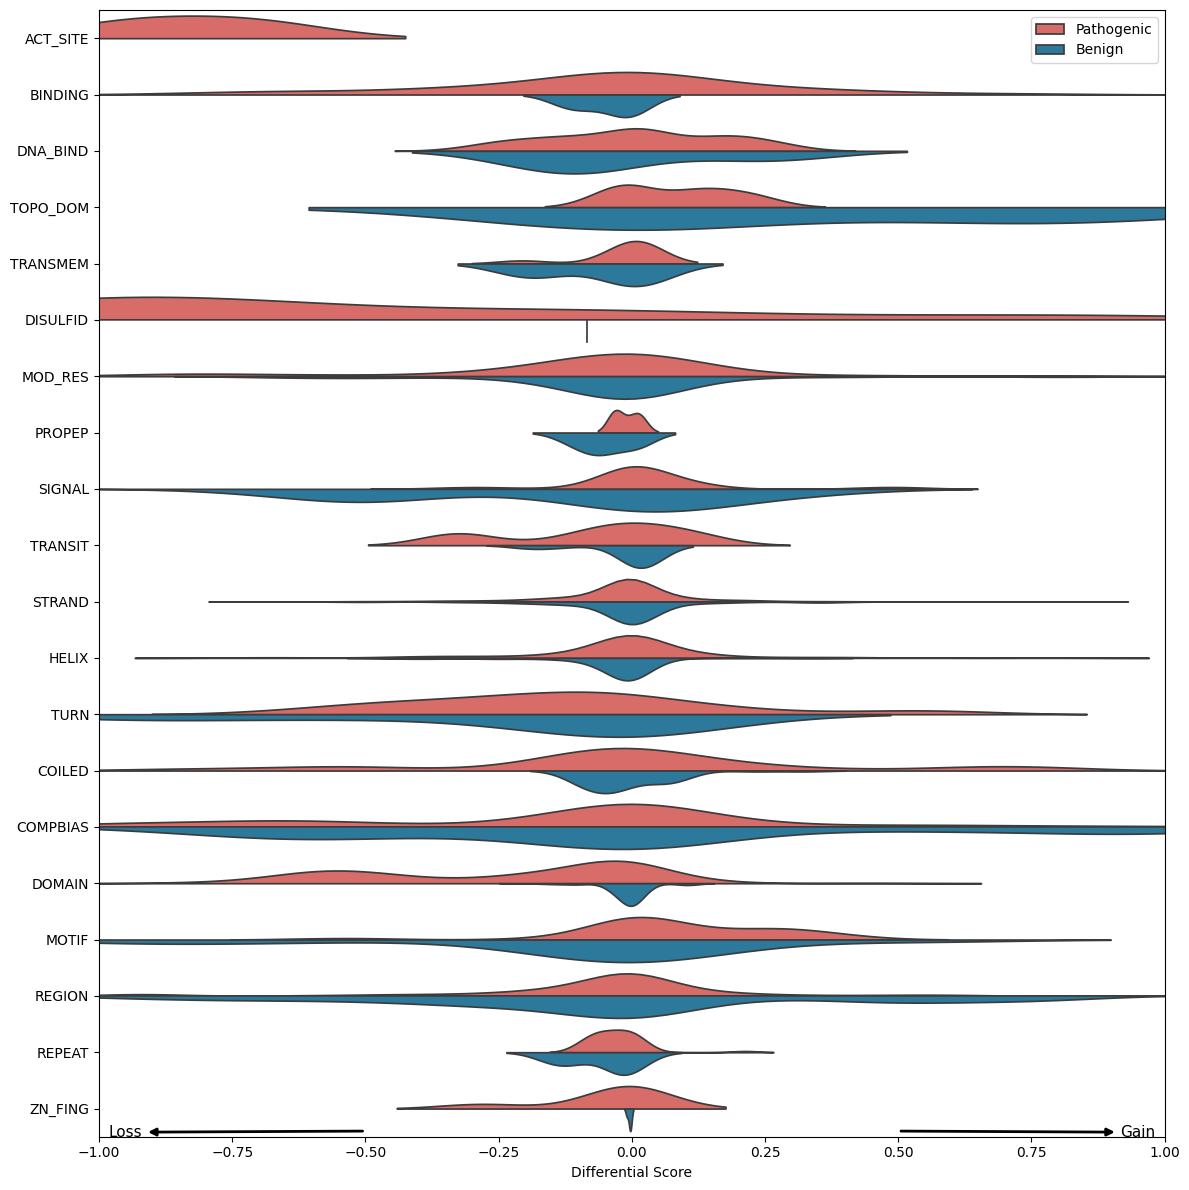

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is ready for plotting
plt.figure(figsize=(12, 12))
sns.violinplot(
    data=ridge_data, 
    x='score', 
    y='feature', 
    hue='Assertion', 
    split=True, 
    scale='width', 
    inner=None,  # Remove dash lines inside the violin plot
    palette={"Benign": "#1B80ADFF", "Pathogenic": "#EA5B57FF"}  # Custom colors
)

# Add a horizontal arrow spanning the plot
plt.annotate(
    'Loss', 
    xy=(-.5, 19.4), xytext=(-0.95, 19.5),  # Arrow points to the left
    arrowprops=dict(arrowstyle='<|-', color='black', lw=2), 
    fontsize=11, color='black', ha='center'
)

plt.annotate(
    'Gain', 
    xy=(0.5, 19.4), xytext=(0.95, 19.5),  # Arrow points to the right
    arrowprops=dict(arrowstyle='<|-', color='black', lw=2), 
    fontsize=11, color='black', ha='center'
)

# X and Y labels
plt.ylabel('')
plt.xlabel('Differential Score')
plt.legend(title=None, bbox_to_anchor=(1, 1))  # Remove title from legend
plt.xlim([-1,1])
plt.tight_layout()

# Save the plot
plt.savefig("../res/figures/diff_scores.png", dpi=300, format="png", bbox_inches="tight")
plt.savefig("../res/figures/diff_scores.pdf", dpi=300, format="pdf", bbox_inches="tight")

# Show the plot
plt.show()


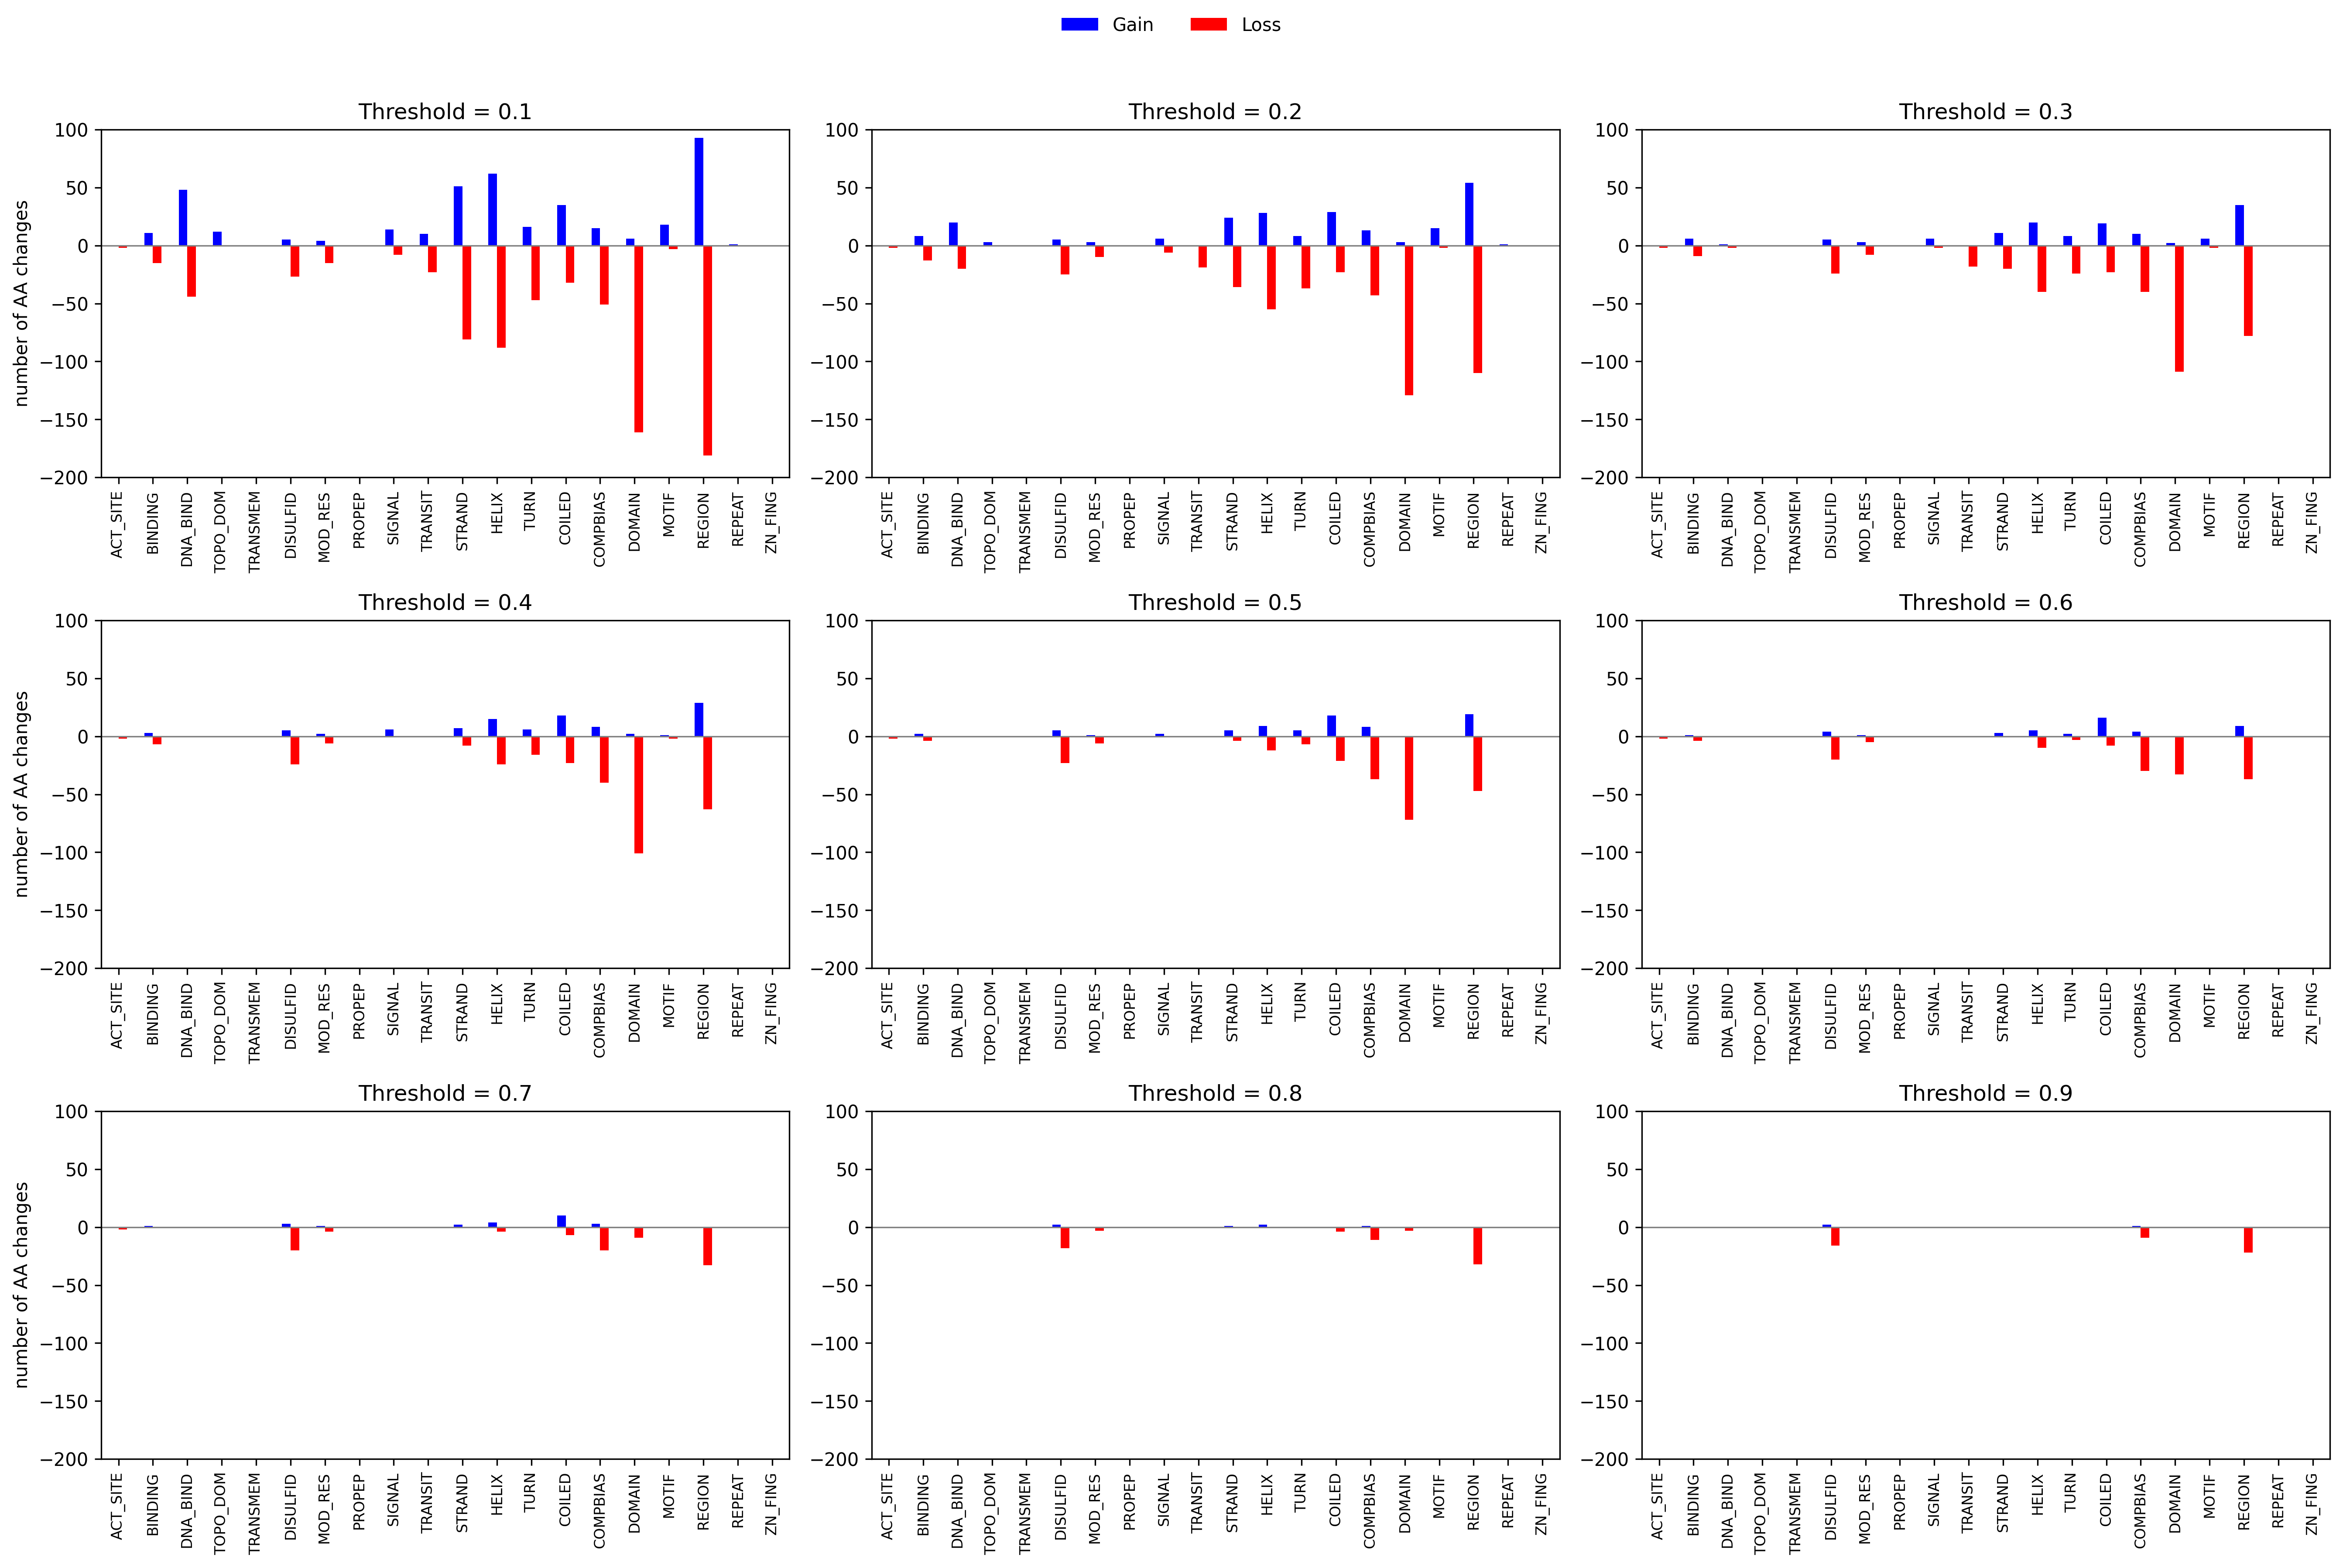

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

thresholds = [round(t, 1) for t in np.arange(0.1, 1.0, 0.1)]
fig, axes = plt.subplots(3, 3, figsize=(18, 12), dpi=300)
axes = axes.flatten()  # Flatten 3x3 grid to simplify indexing

for i, threshold in enumerate(thresholds):
    ax = axes[i]

    # Aggregate changes for pathogenic variants
    patho_changes = clingen_vars.loc[
        clingen_vars["Assertion"] == "Pathogenic",
        [f"n_gain_{f}_th{threshold}" for f in all_features_re] +
        [f"n_loss_{f}_th{threshold}" for f in all_features_re]
    ].sum()

    # Build DataFrame
    patho_changes_df = {
        'Feature': [],
        'Gain': [],
        'Loss': []
    }

    for feature_re in all_features_re:
        patho_changes_df["Feature"].append(feature_re)
        patho_changes_df["Gain"].append(patho_changes[f"n_gain_{feature_re}_th{threshold}"])
        patho_changes_df["Loss"].append(-patho_changes[f"n_loss_{feature_re}_th{threshold}"])  # negative for visual contrast

    df = pd.DataFrame(patho_changes_df).set_index("Feature")

    df.plot(kind='bar', ax=ax, color={'Gain': 'blue', 'Loss': 'red'}, legend=False)
    ax.set_title(f"Threshold = {threshold}")
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df.index, rotation=90, fontsize=8)
    ax.set_ylim(-200, 100)
    ax.set_xlabel('')
    ax.set_ylabel('number of AA changes' if i % 3 == 0 else '')  # only leftmost plots get y-axis label

# Add one legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.savefig("../res/figures/AAchanges_patho_barplot_grid.png", format='png', bbox_inches='tight', dpi=300)
plt.show()


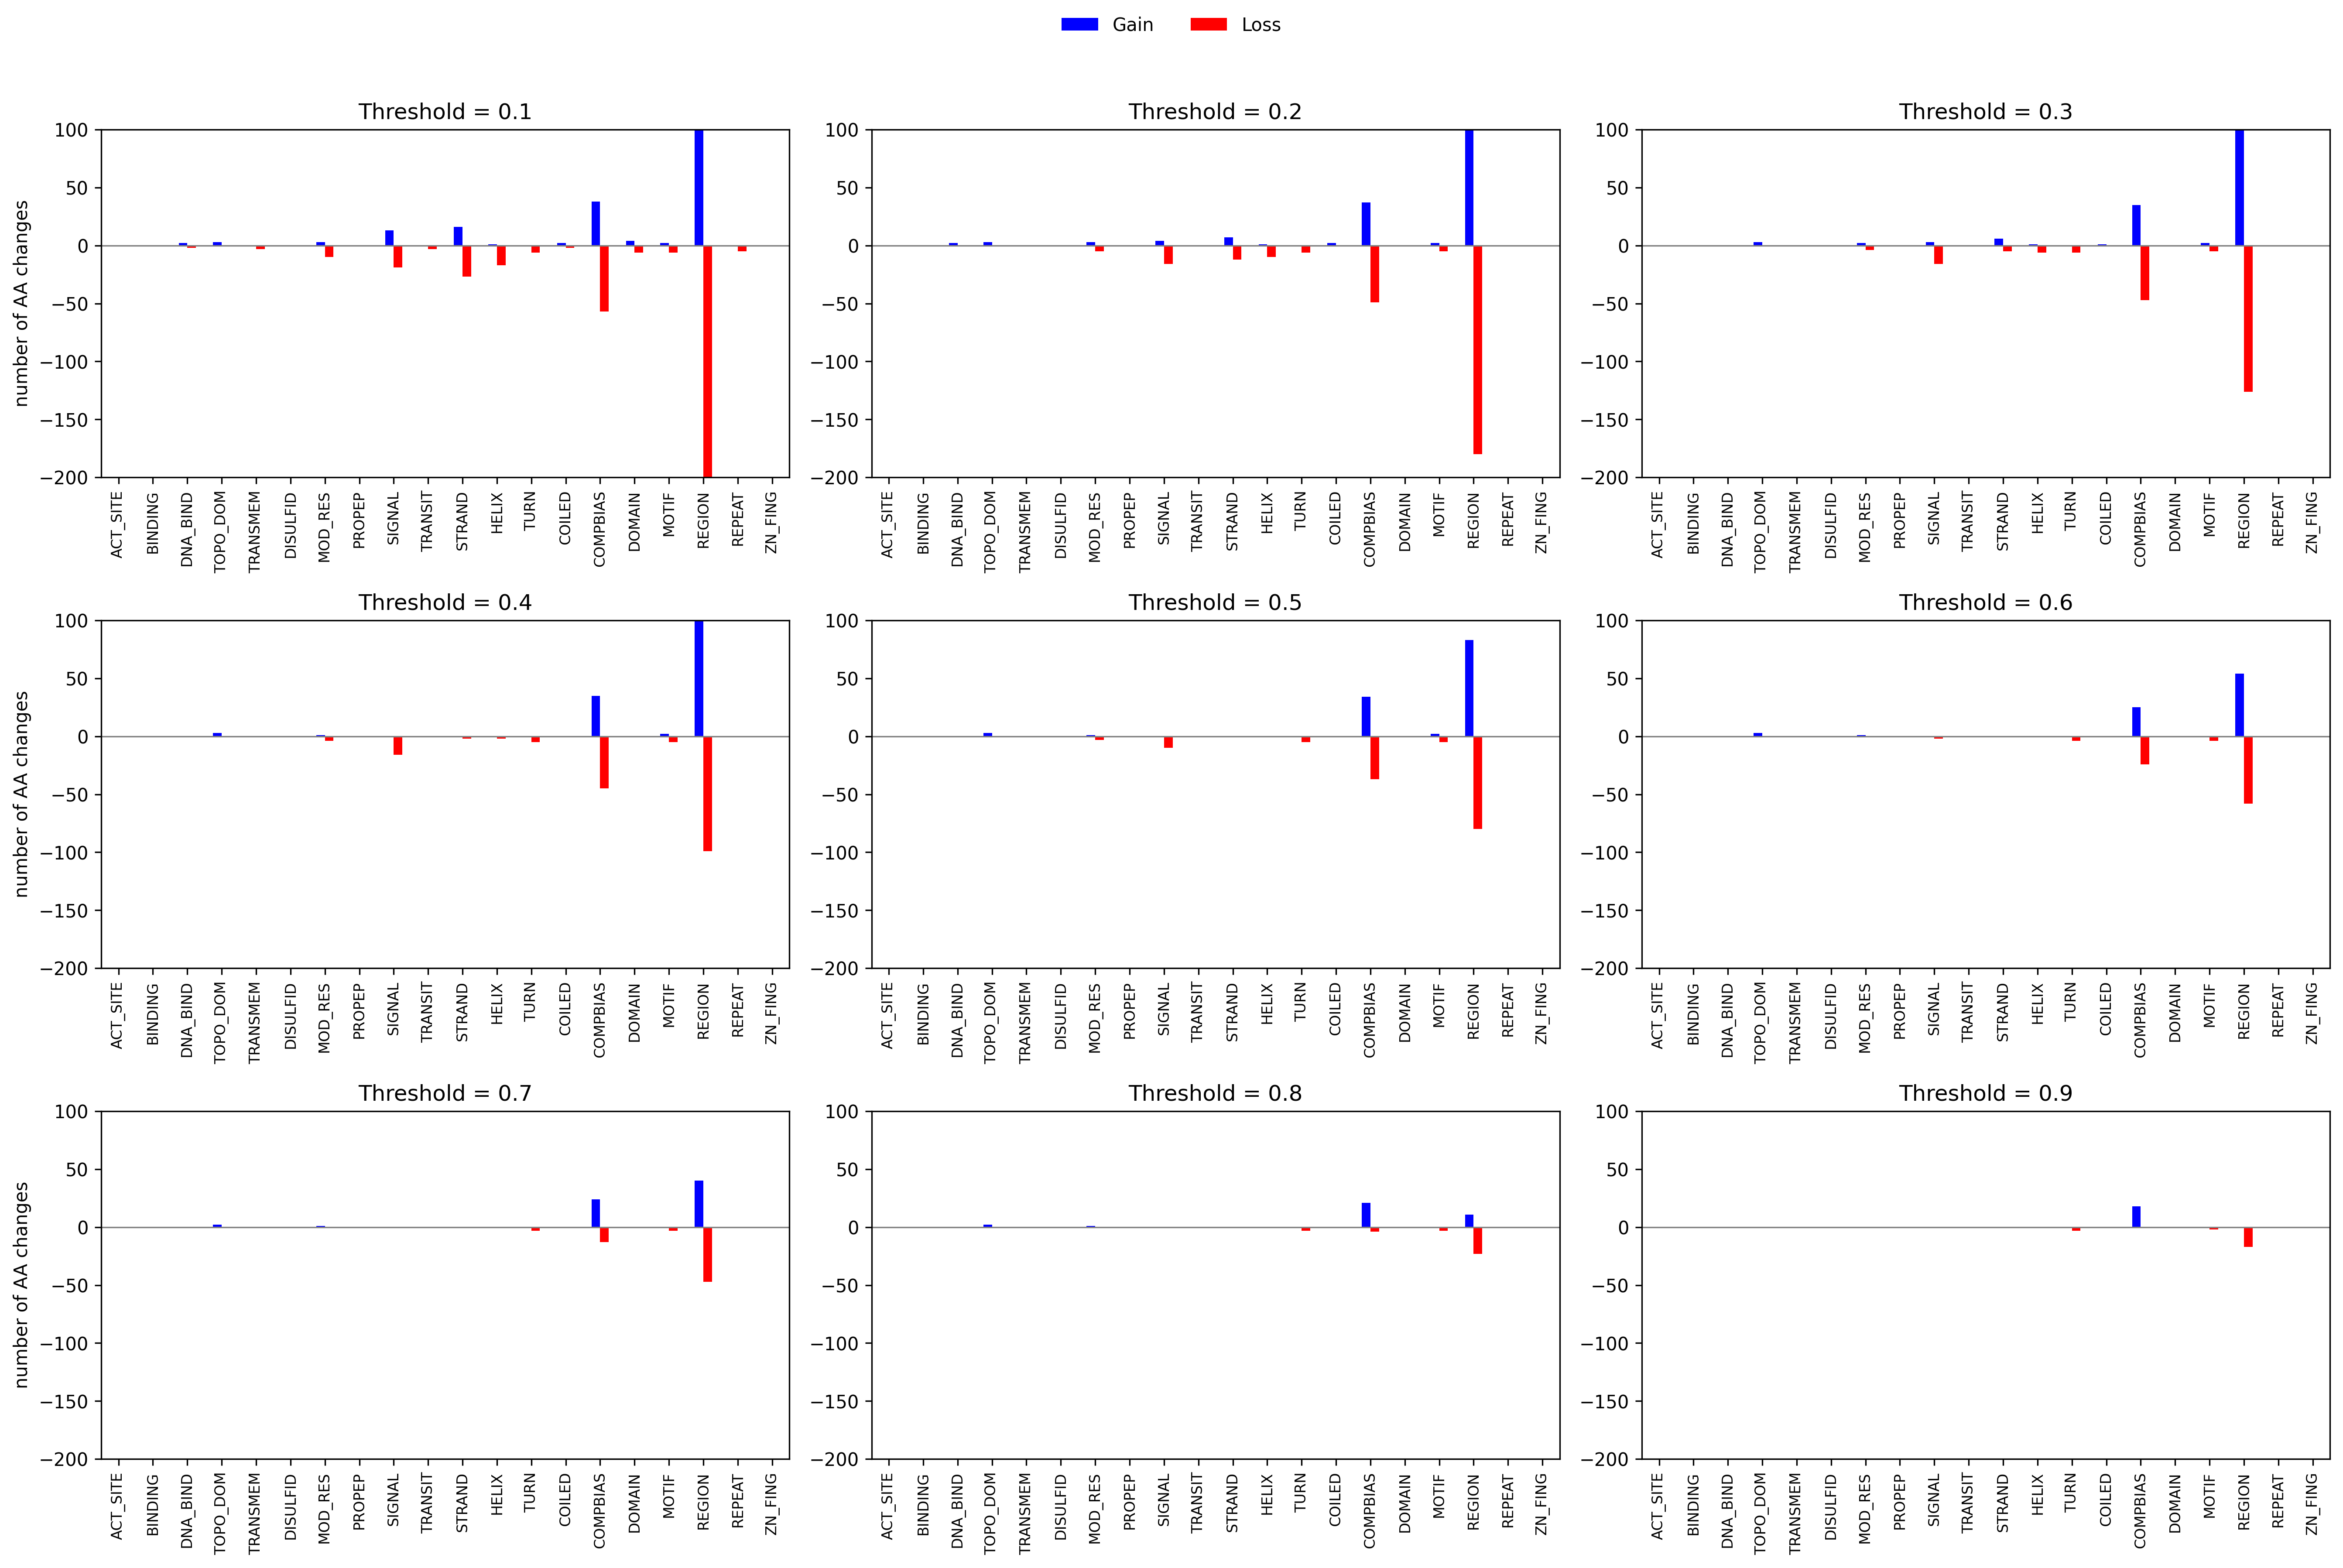

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

thresholds = [round(t, 1) for t in np.arange(0.1, 1.0, 0.1)]
fig, axes = plt.subplots(3, 3, figsize=(18, 12), dpi=300)
axes = axes.flatten()  # Flatten 3x3 grid to simplify indexing

for i, threshold in enumerate(thresholds):
    ax = axes[i]

    # Aggregate changes for pathogenic variants
    patho_changes = clingen_vars.loc[
        clingen_vars["Assertion"] == "Benign", # changed this
        [f"n_gain_{f}_th{threshold}" for f in all_features_re] +
        [f"n_loss_{f}_th{threshold}" for f in all_features_re]
    ].sum()

    # Build DataFrame
    patho_changes_df = {
        'Feature': [],
        'Gain': [],
        'Loss': []
    }

    for feature_re in all_features_re:
        patho_changes_df["Feature"].append(feature_re)
        patho_changes_df["Gain"].append(patho_changes[f"n_gain_{feature_re}_th{threshold}"])
        patho_changes_df["Loss"].append(-patho_changes[f"n_loss_{feature_re}_th{threshold}"])  # negative for visual contrast

    df = pd.DataFrame(patho_changes_df).set_index("Feature")

    df.plot(kind='bar', ax=ax, color={'Gain': 'blue', 'Loss': 'red'}, legend=False)
    ax.set_title(f"Threshold = {threshold}")
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df.index, rotation=90, fontsize=8)
    ax.set_ylim(-200, 100)
    ax.set_xlabel('')
    ax.set_ylabel('number of AA changes' if i % 3 == 0 else '')  # only leftmost plots get y-axis label

# Add one legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.savefig("../res/figures/AAchanges_benign_barplot_grid.png", format='png', bbox_inches='tight', dpi=300) # changed this
plt.show()


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_diff_results_zoomed(diff_results, sequence_length, gene, title=None, num_features=len(all_features), threshold=0, save=True):

  loss_matrix = np.zeros((num_features, sequence_length))
  gain_matrix = np.zeros((num_features, sequence_length))

  for i in range(num_features):
    feature_re = all_features_re[i]
    loss_positions = diff_results[f"{feature_re}_loss"]
    gain_positions = diff_results[f"{feature_re}_gain"]
    k = 0
    for pos in loss_positions:
        loss_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_loss_score"][k])
        k += 1
    k = 0
    for pos in gain_positions:
        gain_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_gain_score"][k])
        k += 1

  feature_matrix = gain_matrix - loss_matrix

  # Define a custom colormap and create a norm
  cmap = sns.color_palette("coolwarm", as_cmap=True).reversed()
  norm = plt.Normalize(-1, 1)

  # Create two subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.05})

  # Plot data on both axes
  for ax in [ax1, ax2]:
      for i in range(num_features):
          for j in range(sequence_length):
              if np.abs(feature_matrix[i, j]) > threshold:  # Only plot non-zero entries
                  if ax == ax1 and j < sequence_length // 2:
                      ax.scatter(j+2, i+1, marker='o', color=cmap(norm(feature_matrix[i, j])), s=50)
                      ax.plot([0, j + 2], [i + 1, i + 1], color='gray', linestyle='dashed', linewidth=0.5)
                  elif ax == ax2 and j >= sequence_length // 2:
                      ax.scatter(j+2 - sequence_length // 2, i+1, marker='o', color=cmap(norm(feature_matrix[i, j])), s=50)

  # Adjust axes limits and spines
  ax1.set_xlim(0, sequence_length // 4)
  ax1.set_xticks(list(range(0, sequence_length//4, 50)))
  ax2.set_xlim(sequence_length//10 * 9, sequence_length)  # Adjust this based on your data
  ax2.set_xticks(list(range((sequence_length//10 * 9)//50 * 50, sequence_length, 50)))

  # Hide the spines and ticks to make it look like a single continuous axis
  ax1.spines['right'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax1.yaxis.tick_left()
  ax2.yaxis.tick_right()
  ax2.tick_params(labelleft=False)


  # Adding diagonal cut lines to indicate a break in the axis
  d = .012  # proportion of vertical to horizontal extent of the slanted line
  kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
  ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
  ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

  kwargs.update(transform=ax2.transAxes)  # apply the transformation to the second axis
  ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
  ax2.plot((-d, +d), (-d, +d), **kwargs)

  ax1.set_xlabel('Amino acid position')
  ax2.set_xlabel('')
  #ax.set_title(title) # added
  ax1.set_yticks(range(1, num_features+1))
  ax1.set_yticklabels(all_features)
  #ax2.set_yticklabels([])  # remove y labels on the second plot

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])  # Fake up the array of the scalar mappable. Necessary since no mappable object was actually created.
  cbar = plt.colorbar(sm, ax=[ax1, ax2], aspect=20)
  cbar.ax.get_yaxis().labelpad = 15
  cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
  cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
  cbar.ax.text(1.0, -0.05, 'Loss', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)
  cbar.ax.text(1.0, 1.05, 'Gain', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)

  if save:
      #plt.savefig(f'../res/figures_temp/{gene}_threshold{threshold}.png', format='png', dpi=300, bbox_inches='tight')
      plt.savefig(f'../res/figures/{gene}_threshold{threshold}.png', format='png', dpi=300, bbox_inches='tight')

  plt.show()



In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_diff_results_continuous(diff_results, sequence_length, gene, title=None, num_features=len(all_features), threshold=0, save=True):

  loss_matrix = np.zeros((num_features, sequence_length))
  gain_matrix = np.zeros((num_features, sequence_length))

  for i in range(num_features):
    feature_re = all_features_re[i]
    loss_positions = diff_results[f"{feature_re}_loss"]
    gain_positions = diff_results[f"{feature_re}_gain"]
    k = 0
    for pos in loss_positions:
        loss_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_loss_score"][k])
        k += 1
    k = 0
    for pos in gain_positions:
        gain_matrix[i, pos - 1] = np.abs(diff_results[f"{feature_re}_gain_score"][k])
        k += 1

  feature_matrix = gain_matrix - loss_matrix

  # Define colormap and normalization
  cmap = sns.color_palette("coolwarm", as_cmap=True).reversed()
  norm = plt.Normalize(-1, 1)

  # Create one plot
  fig, ax = plt.subplots(figsize=(15, 7))

  # Plot non-zero entries
  for i in range(num_features):
      for j in range(sequence_length):
          if np.abs(feature_matrix[i, j]) > threshold:
              ax.scatter(j + 1, i + 1, marker='o', color=cmap(norm(feature_matrix[i, j])), s=50)
              ax.plot([0, j + 1], [i + 1, i + 1], color='gray', linestyle='dashed', linewidth=0.5)


  # Axes settings
  ax.set_xlim(0, sequence_length + 1)
  ax.set_xlabel('Amino acid position')
  #ax.set_title(title) # added
  ax.set_yticks(range(1, num_features + 1))
  ax.set_yticklabels(all_features)

  # Colorbar
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=ax, aspect=20)
  cbar.ax.get_yaxis().labelpad = 15
  cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
  cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
  cbar.ax.text(1.0, -0.05, 'Loss', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)
  cbar.ax.text(1.0, 1.05, 'Gain', va='bottom', ha='right', transform=cbar.ax.transAxes, fontsize=10)

  if save:
      #plt.savefig(f'../res/figures_temp/{gene}_threshold{threshold}_continuous_{title}.png', format='png', dpi=300, bbox_inches='tight')
      plt.savefig(f'../res/figures/{gene}_threshold{threshold}_continuous.png', format='png', dpi=300, bbox_inches='tight')
      
  plt.show()


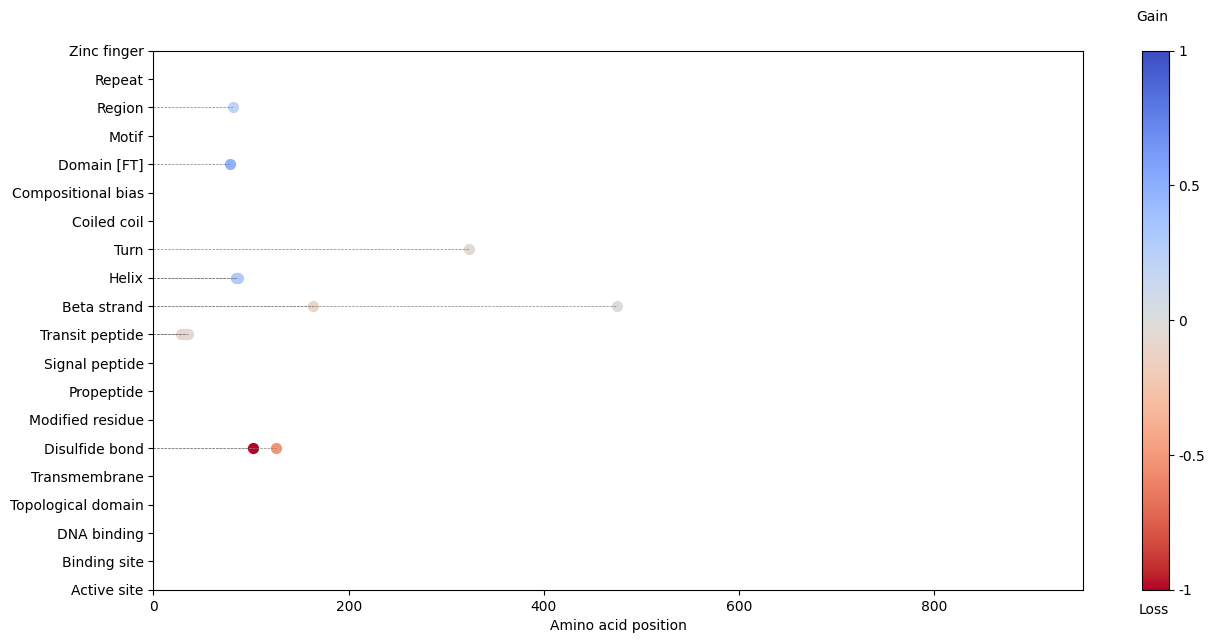

In [71]:
example1_idx = clingen_vars["n_loss_DISULFID_th0.3"].idxmax()

plot_diff_results_continuous(clingen_vars.iloc[example1_idx]["diff_results"],
                  clingen_vars.iloc[example1_idx]["Length"],
                  gene=f"{clingen_vars.iloc[example1_idx]['SYMBOL']}",
                  threshold=0, 
                  save=True)

In [72]:
clingen_vars.iloc[example1_idx]

Unnamed: 0                                                            486
#Variation                        NM_000152.3(GAA):c.307T>G (p.Cys103Gly)
ClinVar Variation Id                                                92483
Allele Registry Id                                               CA220404
HGVS Expressions        NM_000152.3:c.307T>G, NC_000017.11:g.80104893T...
                                              ...                        
all_scores_DOMAIN       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_MOTIF        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REGION       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REPEAT       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_ZN_FING      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 486, Length: 410, dtype: object

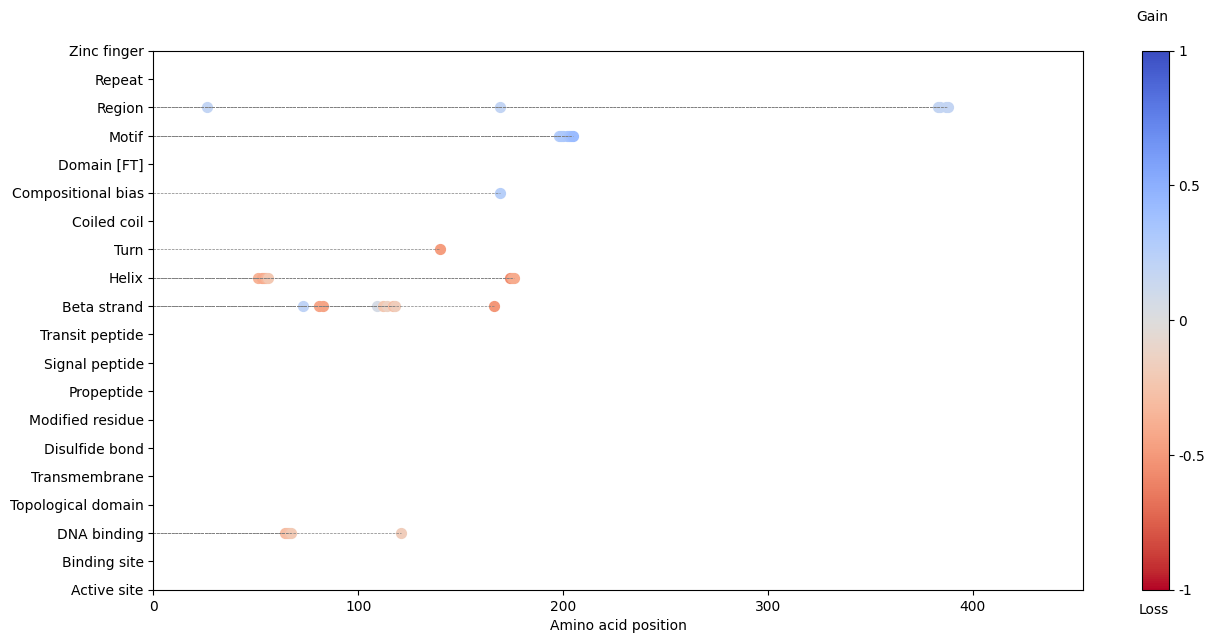

In [73]:
example2_idx = clingen_vars["n_loss_DNA_BIND_th0.3"].idxmax()

plot_diff_results_continuous(clingen_vars.iloc[example2_idx]["diff_results"],
                  clingen_vars.iloc[example2_idx]["Length"],
                  gene=f"{clingen_vars.iloc[example2_idx]['SYMBOL']}",
                  threshold=0, 
                  save=True)

In [74]:
clingen_vars.iloc[example2_idx]

Unnamed: 0                                                            142
#Variation                      NM_001754.5(RUNX1):c.400G>C (p.Ala134Pro)
ClinVar Variation Id                                                14468
Allele Registry Id                                               CA248623
HGVS Expressions        NM_001754.5:c.400G>C, NC_000021.9:g.34880665C>...
                                              ...                        
all_scores_DOMAIN       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_MOTIF        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REGION       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REPEAT       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_ZN_FING      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 142, Length: 410, dtype: object

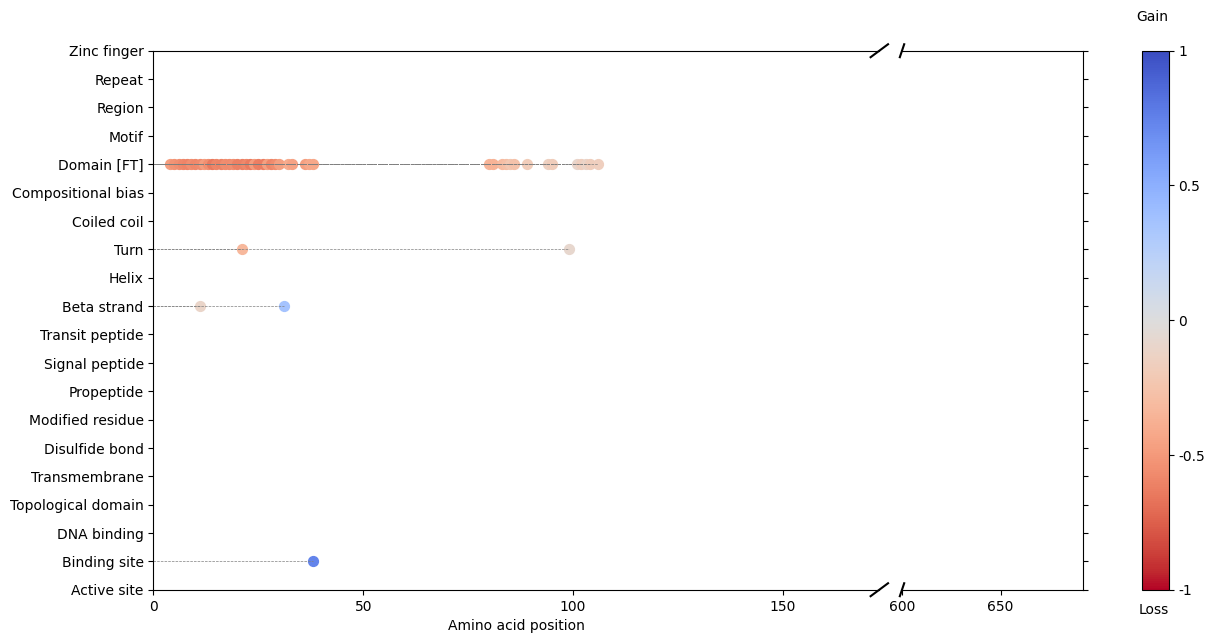

In [75]:
example3_idx = clingen_vars["n_loss_DOMAIN_th0.3"].idxmax()

plot_diff_results_zoomed(clingen_vars.iloc[example3_idx]["diff_results"],
                  clingen_vars.iloc[example3_idx]["Length"],
                  gene=f"{clingen_vars.iloc[example3_idx]['SYMBOL']}",
                  threshold=0, 
                  save=True)

In [76]:
clingen_vars.iloc[example3_idx]

Unnamed: 0                                                            675
#Variation                  NM_001033855.3(DCLRE1C):c.103C>G (p.His35Asp)
ClinVar Variation Id                                                 4674
Allele Registry Id                                               CA117007
HGVS Expressions        NM_001033855.3:c.103C>G, NC_000010.11:g.149539...
                                              ...                        
all_scores_DOMAIN       [0.0, 0.0, -0.4731719, -0.5301209, -0.55369735...
all_scores_MOTIF        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REGION       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REPEAT       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_ZN_FING      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 675, Length: 410, dtype: object

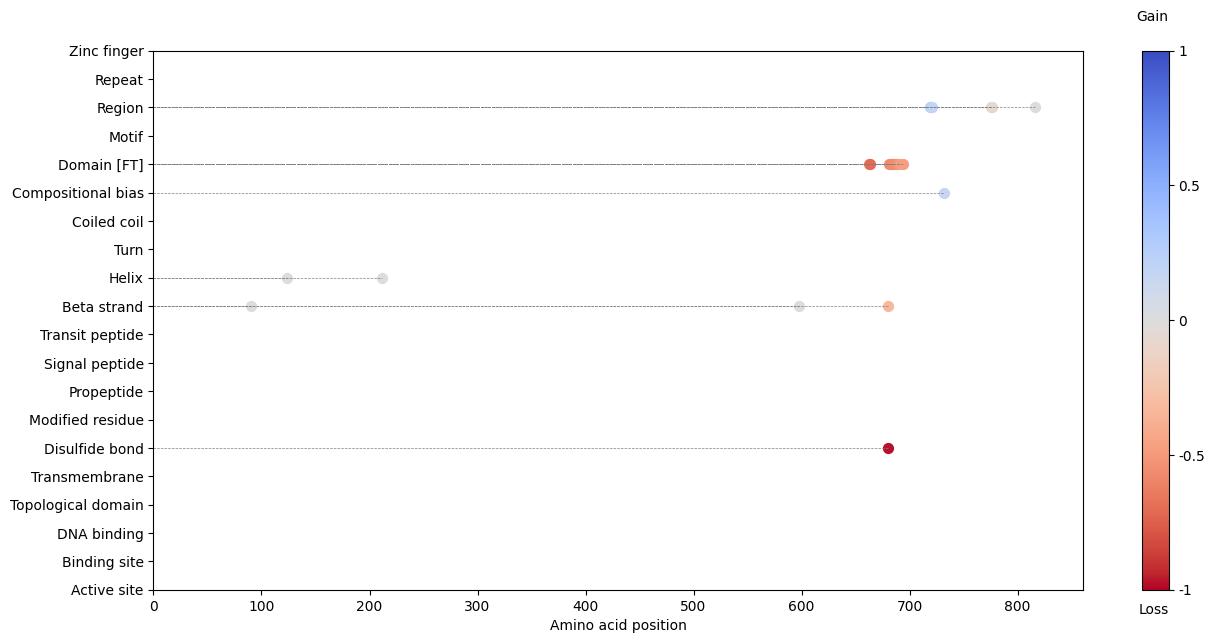

In [77]:
example4_idx = 303

plot_diff_results_continuous(clingen_vars.iloc[example4_idx]["diff_results"],
                  clingen_vars.iloc[example4_idx]["Length"],
                  gene=f"{clingen_vars.iloc[example4_idx]['SYMBOL']}",
                  threshold=0, 
                  save=True)

In [78]:
clingen_vars.iloc[example4_idx]

Unnamed: 0                                                            303
#Variation                      NM_000527.5(LDLR):c.2043C>G (p.Cys681Trp)
ClinVar Variation Id                                               252188
Allele Registry Id                                             CA10585743
HGVS Expressions        NM_000527.5:c.2043C>G, ENST00000558518.6:c.204...
                                              ...                        
all_scores_DOMAIN       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_MOTIF        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REGION       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_REPEAT       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
all_scores_ZN_FING      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 303, Length: 410, dtype: object